
# Differential Gene Expression Analysis: FRDA vs Control

**Author:** Jamil Hanouneh  

**Email:** jamil.hanouneh1997@gmail.com

---



## Purpose
This notebook performs a comprehensive differential gene expression (DGE) analysis to identify genes that are significantly altered in **Friedreich's Ataxia (FRDA)** patients compared to healthy controls. FRDA is a neurodegenerative disorder caused by reduced expression of the **FXN (frataxin)** gene.

## Workflow Overview
1. **Data Loading & Preparation**
   - Load RNA-seq count data from the GSE104288 dataset
   - Classify samples into FRDA (F-prefix) and Control (CTRL) groups
   - Apply log2 transformation to stabilize variance
2. **Quality Control (PCA)**
   - Perform PCA to visualize sample clustering
   - Verify separation between FRDA and control groups
   - Identify potential outliers or batch effects
3. **Differential Expression Testing**
   - Welch's t-test per gene (unequal variance assumption)
   - Compute log2 fold-change (FRDA vs CTRL)
   - Apply Benjamini-Hochberg FDR correction
   - Rank genes by adjusted p-value (padj)
4. **FXN Gene Analysis**
   - Examine FXN expression and test significance
   - Compute gene-wise correlation with FXN
5. **Gene Family Enrichment**
   - Test targeted families (SLC, EIF, Ribosomal cyt/mito) via Mann-Whitney U
6. **Visualization**
   - PCA plot, Volcano plot, Family-shift bar plot
7. **Predictive Modeling (Optional)**
   - Logistic regression with top 200 DE genes (5-fold CV, AUC)

## Outputs
- `DE_results_FRDA_vs_CTRL.tsv`: Differential expression results
- `Signature_shifts.tsv`: Gene family enrichment statistics
- Three plotted figures (displayed in notebook): PCA, volcano, family shifts

## Statistical Methods
- **Welch's t-test**: unequal variances
- **Benjamini-Hochberg FDR**: multiple testing correction
- **Pearson correlation**: correlation with FXN expression
- **Mann-Whitney U**: enrichment analysis

## Dependencies
`numpy, pandas, scipy, statsmodels, matplotlib, scikit-learn`

---



## 0) Setup & Data Path
Update `DATA_PATH` to point to your local copy of the **GSE104288** count matrix (tab-delimited).  
The first column should contain gene identifiers; columns correspond to samples.


In [2]:

import re, numpy as np, pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Display options (optional)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)


In [3]:

# >>>> EDIT THIS PATH TO YOUR LOCAL FILE <<<<
DATA_PATH = "Dataset/GSE104288_DESeq_counts.txt"  # e.g., "./Dataset/GSE104288_DESeq_counts.txt"


## 1) Data Preparation & Transformation

In [4]:

# File I/O - Load raw count matrix
counts = pd.read_csv(DATA_PATH, sep="\t")
counts = counts.rename(columns={counts.columns[0]: "gene"})  # Standardize first column name
counts = counts.set_index("gene")  # Set gene identifiers as row labels

# Classify samples into experimental groups based on column names
samples = counts.columns.tolist()
groups = pd.Series(["FRDA" if re.match(r"^F", s) else "CTRL" for s in samples], index=samples, name="group")

# Select labeled samples and log2-transform to stabilize variance
X = counts.loc[:, groups.index]
X_log = np.log2(X + 1)

X_log.head()


,C1650,C2036,C2153,C2169,C21808,C2671,C288,C3348,C3652,C3956,C5879,C7492,C7522,C7525,C8399,C_UF,C_UM,F130,F156,F188,F203,F281,F3665,F4078,F4192,F4230,F4259,F4497,F4509,F4627,F4654,F4675,F66,F68,F88
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1BG,7.787543,7.458626,8.254023,7.978048,7.972568,7.764454,7.669712,7.475274,7.914088,7.674538,7.551310,8.577495,8.191142,8.169302,9.036190,7.866260,8.942304,7.680136,7.945496,7.573269,8.497432,7.804573,7.659792,8.014058,7.538622,7.832990,8.080416,7.637729,7.993895,7.955767,7.789061,8.144385,7.299234,7.737318,7.597074
A1BG-AS1,5.992866,5.667962,5.619678,6.333616,5.872997,5.177294,5.874346,5.370008,5.997094,5.877247,5.821524,6.033664,6.110370,5.577227,5.748933,5.427660,5.989227,5.680826,6.139650,5.996995,6.060646,5.360485,5.608177,6.110123,6.279446,6.210231,6.004960,5.603615,6.301377,5.880132,5.878594,5.349142,5.509918,5.704607,5.812053
A2M,9.454350,11.737950,10.789803,12.453618,8.565050,10.609092,9.849852,9.504550,8.116199,8.868877,11.794915,7.351251,11.007574,7.649650,8.378272,9.970624,0.000000,9.527588,9.794005,6.800146,5.922672,9.458437,7.992056,7.057521,6.043329,8.261991,7.304358,10.957448,7.884465,7.678403,6.840967,3.040787,6.665832,6.150841,6.432574
A2M-AS1,3.292457,4.113707,1.744035,5.334741,3.738154,3.252406,3.869334,1.618010,2.330618,2.073815,3.870476,2.008612,2.518121,2.222230,1.174157,4.225100,3.186651,1.553131,4.155076,3.370871,3.847300,2.058137,3.885798,0.000000,4.107506,5.069180,2.307801,4.861187,4.674998,3.707299,2.338730,2.464243,4.296895,3.725918,2.043886
A4GALT,9.632816,9.161961,8.674808,8.445644,9.048043,9.551772,9.498595,9.261098,8.248267,9.328668,8.962543,9.420846,8.955742,7.575334,9.277307,8.962494,8.851200,8.949260,8.945851,9.959748,9.916652,9.107530,10.103167,9.324887,10.914830,9.606892,10.128267,9.453089,9.971515,9.373303,9.496676,9.722862,9.758938,10.519325,9.052464


## 2) Quality Control — PCA

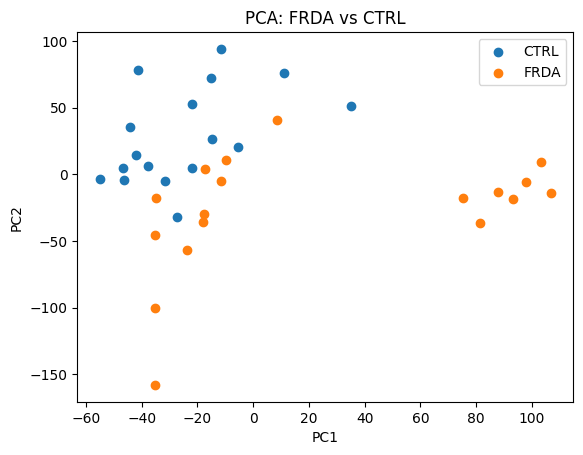

In [5]:

# Z-score normalization across samples (transpose because PCA expects samples × features)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_log.T)

# PCA to 2D
pca = PCA(n_components=2).fit(X_scaled)
pc = pd.DataFrame(pca.transform(X_scaled), columns=["PC1","PC2"], index=X_log.columns)
pc = pc.join(groups)

# Plot
colors = {"FRDA":"tab:red", "CTRL":"tab:blue"}
for g, sub in pc.groupby("group"):
    plt.scatter(sub.PC1, sub.PC2, label=g)
plt.legend(); plt.title("PCA: FRDA vs CTRL"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()


## 3) Differential Expression Testing

In [6]:

# Separate columns by group
frda_cols = groups[groups=="FRDA"].index
ctrl_cols = groups[groups=="CTRL"].index

# Welch's t-test per gene
def welch(row):
    a, b = row[frda_cols], row[ctrl_cols]
    t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
    lfc = (a.mean() - b.mean())
    return pd.Series({"t": t, "p": p, "log2FC": lfc})

de = X_log.apply(welch, axis=1)
de["padj"] = multipletests(de["p"].fillna(1), method="fdr_bh")[1]
de = de.sort_values("padj")

de.head(10)


,t,p,log2FC,padj
gene,,,,
ZDHHC5,9.961959,1.831990e-11,0.353932,3.028462e-07
NTHL1,-8.774558,3.914875e-10,-0.712917,1.617920e-06
ZNF449,-8.921964,2.996405e-10,-0.566903,1.617920e-06
FXN,-9.956764,3.203208e-10,-1.237194,1.617920e-06
RAB34,-8.694167,6.916081e-10,-0.435123,2.286595e-06
THYN1,-8.368189,2.975969e-09,-0.630800,6.471027e-06
PRRG4,8.060987,3.093733e-09,1.920282,6.471027e-06
HIATL1,8.283687,3.131584e-09,0.437207,6.471027e-06
SLC26A2,8.015531,3.589145e-09,0.589909,6.592463e-06


## 4) FXN-Centric Analysis

In [7]:

# FXN expression difference (Welch's t-test)
fxn_expr = X_log.loc["FXN"]
fxn_p = stats.ttest_ind(fxn_expr[frda_cols], fxn_expr[ctrl_cols], equal_var=False).pvalue
fxn_delta = fxn_expr[frda_cols].mean() - fxn_expr[ctrl_cols].mean()
print(f"FXN log2 expression Δ(FRDA-CTRL) = {fxn_delta:.2f}, Welch p = {fxn_p:.2e}")

# Correlation between FXN and all genes
fxn_corr = X_log.apply(lambda g: stats.pearsonr(g, fxn_expr)[0], axis=1)
fxn_corr.name = "corr_with_FXN"
de = de.join(fxn_corr)

de.loc["FXN"]


FXN log2 expression Δ(FRDA-CTRL) = -1.24, Welch p = 3.20e-10


t               -9.956764e+00
p                3.203208e-10
log2FC          -1.237194e+00
padj             1.617920e-06
corr_with_FXN    1.000000e+00
Name: FXN, dtype: float64

## 5) Gene Family Enrichment

Targeted family shifts (median log2FC, MWU p):


,family,median_log2FC,p_MWU,n_genes
0,SLC,0.119372,2.445745e-05,300
1,EIF,-0.063048,4.203454e-03,52
3,Ribosomal_mito,-0.163417,2.440978e-09,79
2,Ribosomal_cyt,-0.403158,2.931352e-20,112


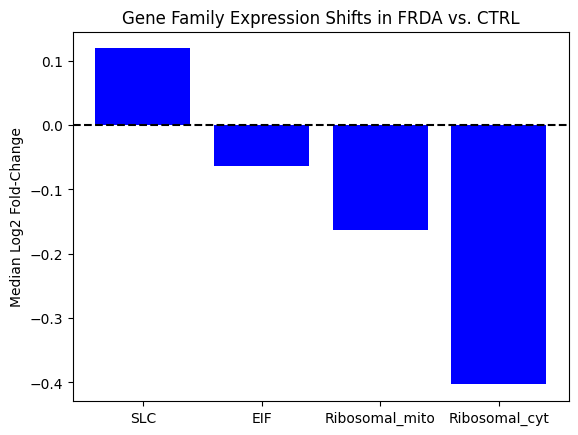

In [8]:

# Define gene families by name patterns
families = {
    "SLC":   X_log.index[X_log.index.str.startswith("SLC")],
    "EIF":   X_log.index[X_log.index.str.startswith("EIF")],
    "Ribosomal_cyt": X_log.index[X_log.index.str.match(r"^RP[SL]")],
    "Ribosomal_mito": X_log.index[X_log.index.str.match(r"^MRP[SL]")],
}

enrich_rows = []
for fam, genes in families.items():
    genes = [g for g in genes if g in de.index]
    if not genes:
        continue
    fam_lfc = de.loc[genes, "log2FC"].dropna()
    bg_lfc  = de.loc[~de.index.isin(genes), "log2FC"].dropna()
    u, p = stats.mannwhitneyu(fam_lfc, bg_lfc, alternative="two-sided")
    enrich_rows.append([fam, fam_lfc.median(), float(p), len(genes)])

enrich = pd.DataFrame(enrich_rows, columns=["family","median_log2FC","p_MWU","n_genes"]).sort_values("median_log2FC", ascending=False)
print("Targeted family shifts (median log2FC, MWU p):")
display(enrich)

# Plot family shifts
plt.bar(enrich['family'], enrich['median_log2FC'], color=['blue' if p < 0.05 else 'gray' for p in enrich['p_MWU']])
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Median Log2 Fold-Change')
plt.title('Gene Family Expression Shifts in FRDA vs. CTRL')
plt.show()


## 6) Visualization — Volcano Plot

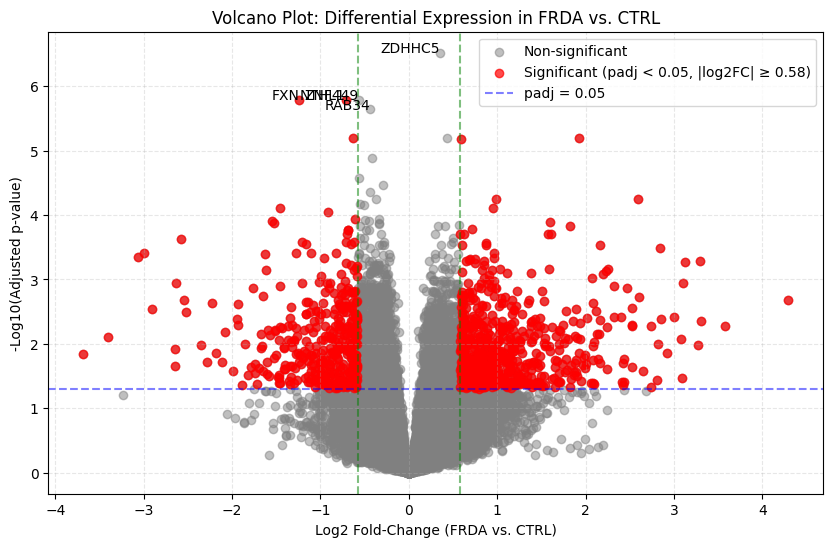

In [9]:

volcano = de.copy()
volcano["neglog10_padj"] = -np.log10(volcano["padj"].replace(0, np.nextafter(0,1)))
hits = volcano[(volcano["padj"] < 0.05) & (volcano["log2FC"].abs() >= 0.58)]

plt.figure(figsize=(10, 6))
plt.scatter(volcano['log2FC'], volcano['neglog10_padj'], c='gray', alpha=0.5, label='Non-significant')
plt.scatter(hits['log2FC'], hits['neglog10_padj'], c='red', alpha=0.7, label='Significant (padj < 0.05, |log2FC| ≥ 0.58)')

genes_to_label = ['FXN', 'ZDHHC5', 'NTHL1', 'ZNF449', 'RAB34']
for gene in genes_to_label:
    if gene in volcano.index:
        plt.text(volcano.loc[gene, 'log2FC'], volcano.loc[gene, 'neglog10_padj'], gene, fontsize=10, ha='right')

plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', alpha=0.5, label='padj = 0.05')
plt.axvline(x=0.58, color='green', linestyle='--', alpha=0.5)
plt.axvline(x=-0.58, color='green', linestyle='--', alpha=0.5)

plt.xlabel('Log2 Fold-Change (FRDA vs. CTRL)')
plt.ylabel('-Log10(Adjusted p-value)')
plt.title('Volcano Plot: Differential Expression in FRDA vs. CTRL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


## 7) Classification Model (Top 200 DE Genes)

In [10]:

top_genes = de.head(200).index
Xclf = X_log.loc[top_genes].T
y = (groups == "FRDA").astype(int).reindex(Xclf.index)

clf = LogisticRegression(max_iter=500)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
auc = cross_val_score(clf, Xclf, y, cv=cv, scoring="roc_auc").mean()
print(f"Logistic regression (top 200 DE genes): mean CV AUC = {auc:.3f}")


Logistic regression (top 200 DE genes): mean CV AUC = 1.000


## 8) Save Results

In [11]:

de.to_csv("DE_results_FRDA_vs_CTRL.tsv", sep="\t")
enrich.to_csv("Signature_shifts.tsv", sep="\t")
print("Saved: DE_results_FRDA_vs_CTRL.tsv and Signature_shifts.tsv")


Saved: DE_results_FRDA_vs_CTRL.tsv and Signature_shifts.tsv
